# Fast Mellin Transform on Pulsars

Let's do some experiments of usin the MFT on pulsars. 

First, let's do the experiment in the [docs]()

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
scale = 1.25
freq = 3.0
x1 = np.linspace(0, 1, num=1024, endpoint=False)
x2 = np.linspace(0, 1, num=scale * len(x1), endpoint=False)
y1 = np.sin(2 * np.pi * freq * x1)

y2 = np.sin(2 * np.pi * freq * x2) / np.sqrt(scale)

# Verify that the two signals have the same energy
np.sum(np.abs(y1)**2), np.sum(np.abs(y2)**2)


(512.0, 512.0)

In [3]:
import librosa

In [4]:
scale1 = librosa.fmt(y1, n_fmt=512)
scale2 = librosa.fmt(y2, n_fmt=512)

<IPython.core.display.Javascript object>


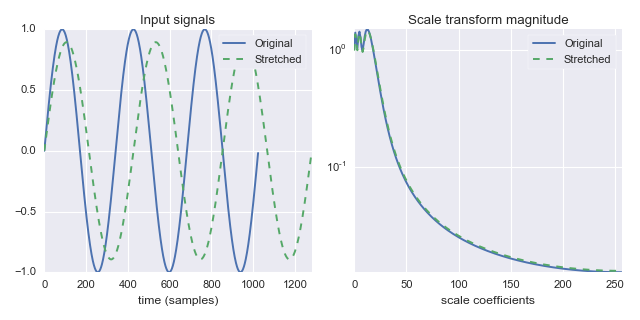

In [5]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(y1, label='Original')
plt.plot(y2, linestyle='--', label='Stretched')
plt.xlabel('time (samples)')
plt.title('Input signals')
plt.legend(frameon=True)
plt.axis('tight')

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(scale1), label='Original')
plt.semilogy(np.abs(scale2), linestyle='--', label='Stretched')
plt.xlabel('scale coefficients')
plt.title('Scale transform magnitude')
plt.legend(frameon=True)
plt.axis('tight')
plt.tight_layout()


Okay, cool. Let's play around with this!

In [6]:
scale = 1.25
freq = 3.0
x1 = np.linspace(0, 1, num=1024, endpoint=False)
x2 = np.linspace(0, 1, num=scale * len(x1), endpoint=False)
y1 = np.sin(2 * np.pi * freq * x1)
y2 = np.sin(2 * np.pi * freq * x1+np.pi/2.0)

# Verify that the two signals have the same energy
np.sum(np.abs(y1)**2), np.sum(np.abs(y2)**2)



(512.0, 512.0)

In [7]:
scale1 = librosa.fmt(y1, n_fmt=512)
scale2 = librosa.fmt(y2, n_fmt=512)

<IPython.core.display.Javascript object>


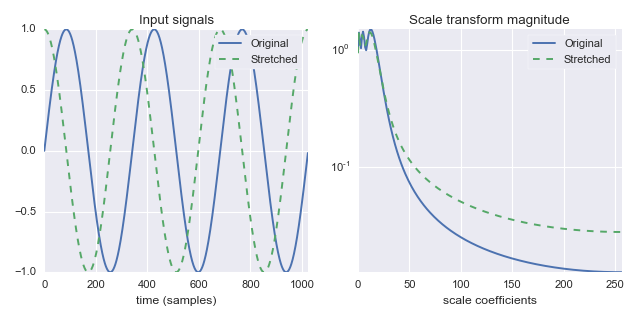

In [8]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(y1, label='Original')
plt.plot(y2, linestyle='--', label='Stretched')
plt.xlabel('time (samples)')
plt.title('Input signals')
plt.legend(frameon=True)
plt.axis('tight')

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(scale1), label='Original')
plt.semilogy(np.abs(scale2), linestyle='--', label='Stretched')
plt.xlabel('scale coefficients')
plt.title('Scale transform magnitude')
plt.legend(frameon=True)
plt.axis('tight')
plt.tight_layout()



Okay, so the scale transform is *not* shift invariant! Good to know!

Let's play more with the shifting:

In [9]:
scale = 2.0
freq = 5.0
x1 = np.linspace(0, 1, num=1024, endpoint=False)
x2 = np.linspace(0, 1, num=1024*scale, endpoint=False)


y1 = np.sin(2 * np.pi * freq * x1)
y2 = np.sin(2 * np.pi * freq * x2)/np.sqrt(scale)

# Verify that the two signals have the same energy
np.sum(np.abs(y1)**2), np.sum(np.abs(y2)**2)



(511.99999999999994, 511.99999999999989)

<IPython.core.display.Javascript object>


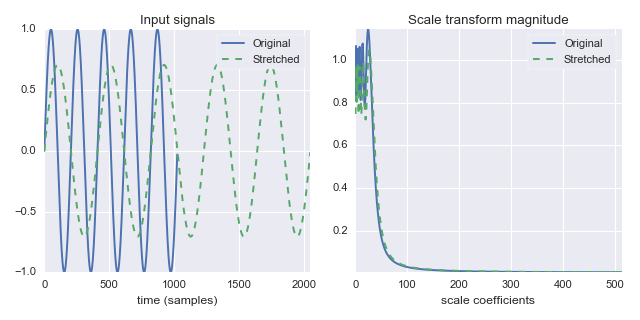

In [10]:
scale1 = librosa.fmt(y1, n_fmt=1024)
scale2 = librosa.fmt(y2, n_fmt=1024)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(y1, label='Original')
plt.plot(y2, linestyle='--', label='Stretched')
plt.xlabel('time (samples)')
plt.title('Input signals')
plt.legend(frameon=True)
plt.axis('tight')

plt.subplot(1, 2, 2)
plt.plot(np.abs(scale1), label='Original')
plt.plot(np.abs(scale2), linestyle='--', label='Stretched')
plt.xlabel('scale coefficients')
plt.title('Scale transform magnitude')
plt.legend(frameon=True)
plt.axis('tight')
plt.tight_layout()


We should be doing this on the autocorrelation function instead of the time series, because the ACF is shift-invariant:

In [40]:
scale = 2.0
freq = 10.0
sr = 1./1024

x1 = np.linspace(0, 1, num=1024, endpoint=False)
x2 = np.linspace(0, 1, num=1024*scale, endpoint=False)

y1 = np.sin(2 * np.pi * freq * x1)
y2 = np.sin(2 * np.pi * freq * x2)/np.sqrt(scale)

ac1 = librosa.autocorrelate(y1, max_size=1024)
ac2 = librosa.autocorrelate(y2, max_size=1024*scale)


# Verify that the two signals have the same energy
ac1 = librosa.util.normalize(ac1, norm=np.inf)
ac2 = librosa.util.normalize(ac2, norm=np.inf)/np.sqrt(scale)
np.sum(np.abs(ac1)**2), np.sum(np.abs(ac2)**2)




(171.49040647966086, 171.24077240316032)

<IPython.core.display.Javascript object>


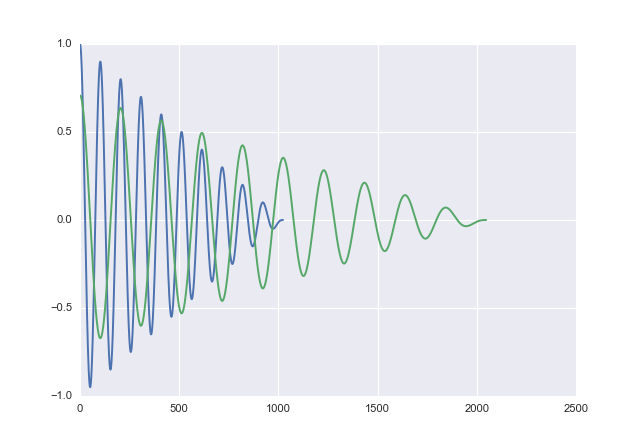

In [41]:
plt.figure()
plt.plot(ac1)
plt.plot(ac2)

<IPython.core.display.Javascript object>


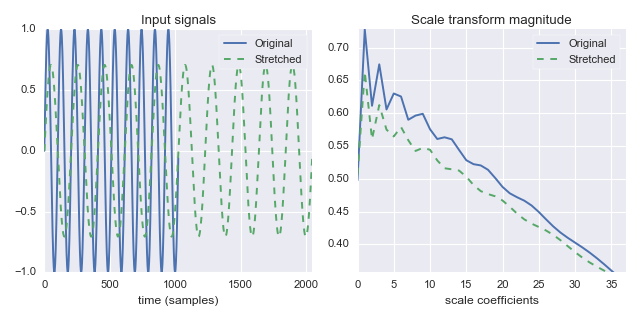

In [42]:

scale1 = librosa.fmt(ac1, n_fmt=256)
scale2 = librosa.fmt(ac2, n_fmt=256)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(y1, label='Original')
plt.plot(y2, linestyle='--', label='Stretched')
plt.xlabel('time (samples)')
plt.title('Input signals')
plt.legend(frameon=True)
plt.axis('tight')

plt.subplot(1, 2, 2)
plt.plot(np.abs(scale1), label='Original')
plt.plot(np.abs(scale2), linestyle='--', label='Stretched')
plt.xlabel('scale coefficients')
plt.title('Scale transform magnitude')
plt.legend(frameon=True)
plt.axis('tight')
plt.tight_layout()



Let's make two different shapes: a periodic time series with one peak and a periodic time series with two peaks.

First, one peak:

In [44]:
def gaussian(x, a, loc, w):
    return a*np.exp(-np.log(np.sqrt(2.*np.pi*w**2.))-((x-loc)**2./w**2.))

In [56]:
period = 2.0
w = 0.05 * period
a = 1.0
loc = 0.4

x = np.linspace(0,1,100,endpoint=False)

<IPython.core.display.Javascript object>


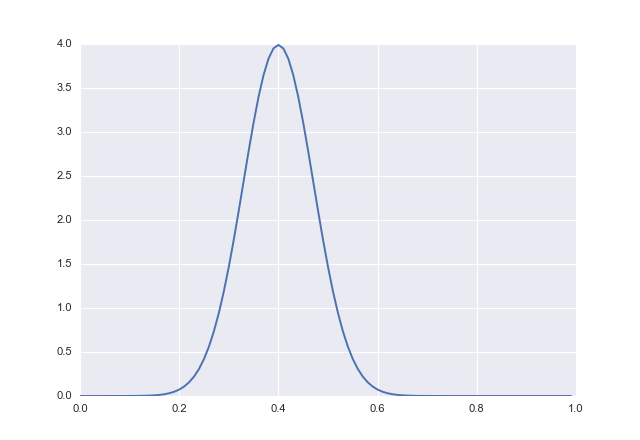

In [57]:
plt.figure()
plt.plot(x, gaussian(x, a, loc, w))

In [107]:
nperiod = 10
scale=2

time, counts1, counts1_s = [], [], []
for i in range(nperiod):
    counts1.extend(gaussian(x, a, loc, w))
    counts1_s.extend(gaussian(x, a, loc, w))
    time.extend(i*period+period*x*scale)

<IPython.core.display.Javascript object>


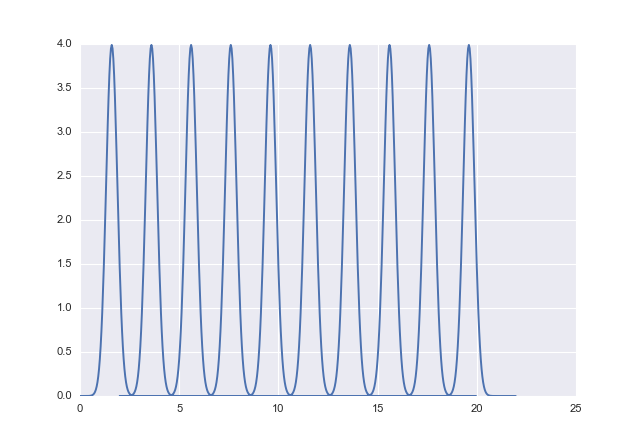

In [109]:
plt.figure()
plt.plot(time, counts1)

#plt.plot(time, counts1_s)

<IPython.core.display.Javascript object>


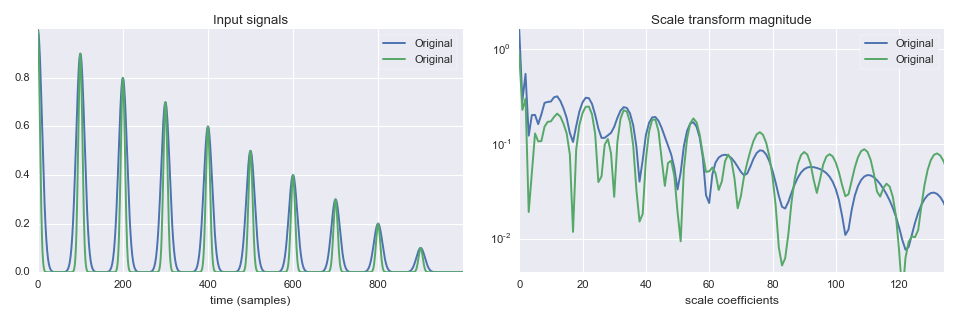

In [104]:
# Verify that the two signals have the same energy
ac1 = librosa.autocorrelate(np.array(counts1), max_size=1024)
ac1_s = librosa.autocorrelate(np.array(counts1_s), max_size=1024)

ac1 = librosa.util.normalize(ac1, norm=np.inf)
ac1_s = librosa.util.normalize(ac1_s, norm=np.inf)

scale1 = librosa.fmt(ac1, n_fmt=512)
scale1_s = librosa.fmt(ac1_s, n_fmt=512)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ac1, label='Original')
plt.plot(ac1_s, label='Original')
plt.xlabel('time (samples)')
plt.title('Input signals')
plt.legend(frameon=True)
plt.axis('tight')

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(scale1), label='Original')
plt.semilogy(np.abs(scale1_s), label='Original')
plt.xlabel('scale coefficients')
plt.title('Scale transform magnitude')
plt.legend(frameon=True)
plt.axis('tight')
plt.tight_layout()





Now a two-beat system:

In [103]:
nperiod = 10

time, counts2 = [], []
for i in range(nperiod):
    counts2.extend(gaussian(x, a, loc, w)+gaussian(x,a/2.0, 0.7,w))
    
    time.extend(i*period+period*x)

<IPython.core.display.Javascript object>


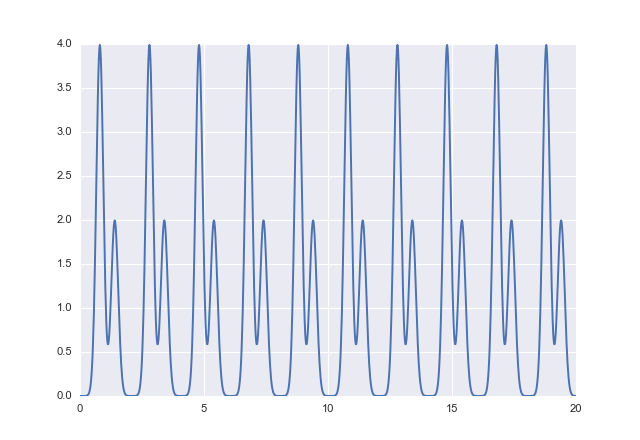

In [100]:
plt.figure()
plt.plot(time, counts2)

<IPython.core.display.Javascript object>


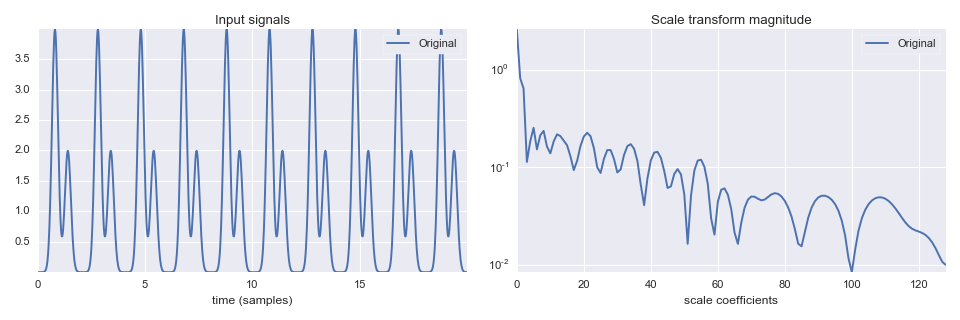

In [101]:
# Verify that the two signals have the same energy
ac2 = librosa.autocorrelate(np.array(counts2), max_size=1024)
ac2 = librosa.util.normalize(ac2, norm=np.inf)

scale2 = librosa.fmt(ac2, n_fmt=256)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(time, counts2, label='Original')
plt.xlabel('time (samples)')
plt.title('Input signals')
plt.legend(frameon=True)
plt.axis('tight')

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(scale2), label='Original')
plt.xlabel('scale coefficients')
plt.title('Scale transform magnitude')
plt.legend(frameon=True)
plt.axis('tight')
plt.tight_layout()





Compare the two:

<IPython.core.display.Javascript object>


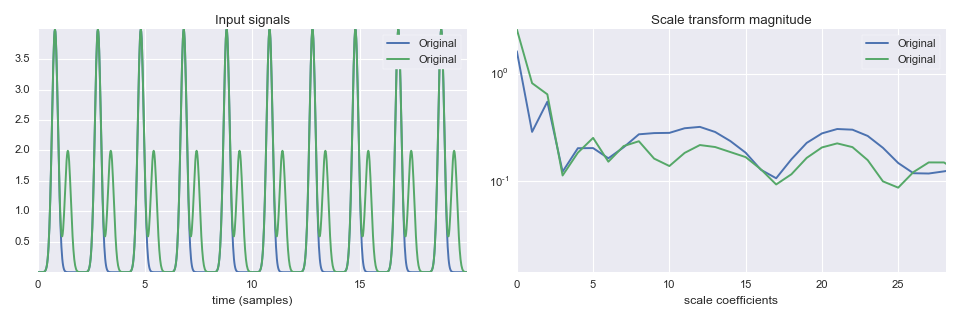

In [77]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(time, counts1, label='Original')
plt.plot(time, counts2, label='Original')
plt.xlabel('time (samples)')
plt.title('Input signals')
plt.legend(frameon=True)
plt.axis('tight')

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(scale1), label='Original')
plt.semilogy(np.abs(scale2), label='Original')
plt.xlabel('scale coefficients')
plt.title('Scale transform magnitude')
plt.legend(frameon=True)
plt.axis('tight')
plt.tight_layout()




Let's use some long time series, chop up them into segments, do DST on those, then average and compare.

In [187]:
nperiod = 1000
x = np.linspace(0,1,300,endpoint=False)

time, counts1 = [], []
for i in range(nperiod):
    counts1.extend(gaussian(x, a, loc, w)+np.random.normal(0, 0.5,size=len(x)))
    time.extend(i*period+period*x)
    
counts1 = np.array(counts1)
time = np.array(time)

<IPython.core.display.Javascript object>


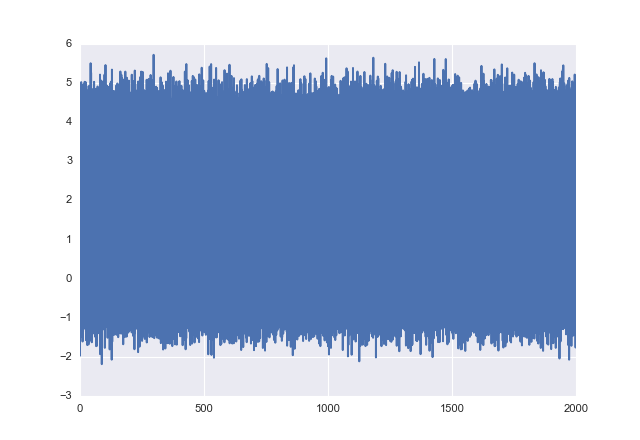

In [188]:
plt.figure()
plt.plot(time, counts1)

<IPython.core.display.Javascript object>


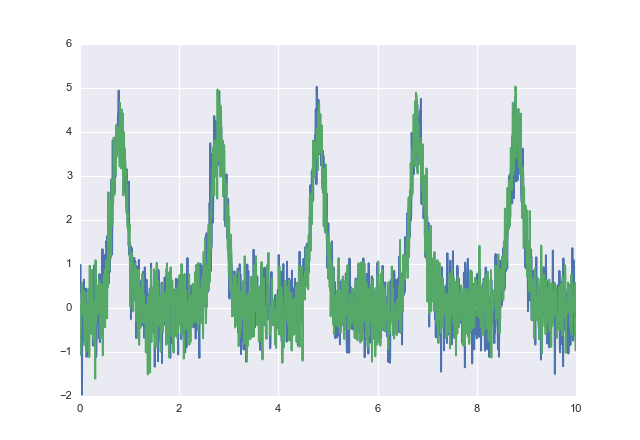

In [190]:
plt.figure()
plt.plot(time[:1500], counts1[:1500])
plt.plot(time[:1500], counts1[1500:3000])

In [191]:
nbins = 300*10
start_ind = 0
end_ind = start_ind + nbins

ac1_all, scale1_all = [], []

while end_ind <= len(counts1):
    ac1 = librosa.autocorrelate(np.array(counts1)[start_ind:end_ind], max_size=1500)
    ac1 = librosa.util.normalize(ac1, norm=np.inf)
    ac1_all.append(ac1)
    
    scale1 = librosa.fmt(ac1, n_fmt=750)
    scale1_all.append(scale1)
    
    start_ind += nbins
    end_ind += nbins

ac1_all = np.array(ac1_all)
scale1_all = np.array(scale1_all)

<IPython.core.display.Javascript object>


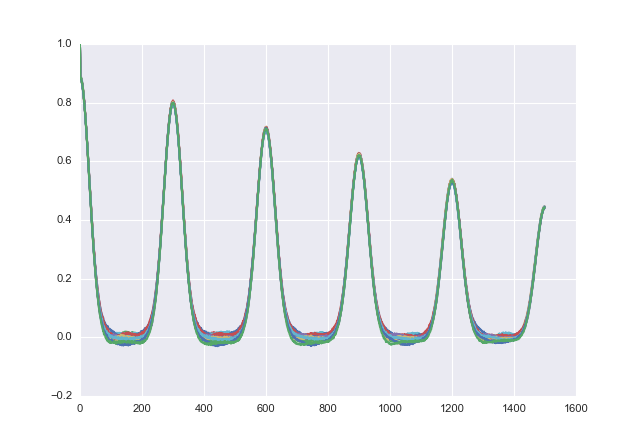

In [192]:
plt.figure()
for ac1 in ac1_all[:20]:
    plt.plot(ac1)

<IPython.core.display.Javascript object>


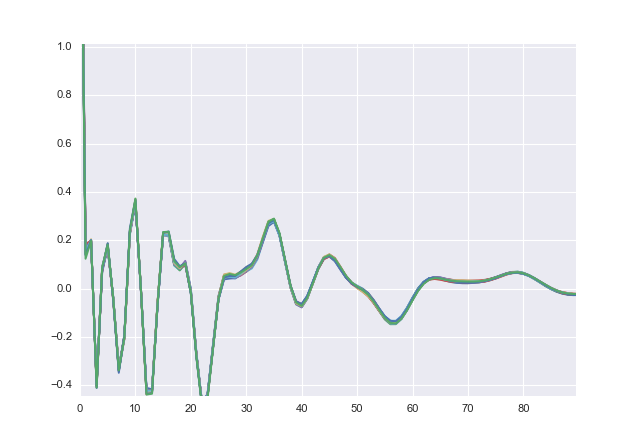

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [193]:
plt.figure()
for scale1 in scale1_all[:20]:
    plt.plot(scale1)

In [195]:
scale1_all.shape

(100, 376)

Let's compute empirical mean and standard deviations:

In [229]:
scale1_mean = np.mean(np.abs(scale1_all), axis=0)
scale1_std = np.std(np.abs(scale1_all), axis=0)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


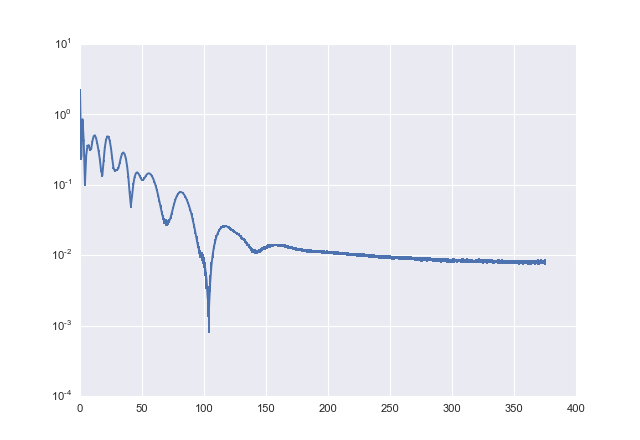

In [231]:
plt.figure()
plt.errorbar(np.arange(len(scale1_mean)), scale1_mean, yerr=scale1_std)
plt.yscale("log")

Let's do the same on the two-peak light curve:

In [198]:
nperiod = 1000
x = np.linspace(0,1,300,endpoint=False)

time, counts2 = [], []
for i in range(nperiod):
    counts2.extend(gaussian(x, a, loc, w)+gaussian(x,a/2.0, 0.7,w) + np.random.normal(0, 0.5,size=len(x)))
    
    time.extend(i*period+period*x)

counts2 = np.array(counts2)
time = np.array(time)

<IPython.core.display.Javascript object>


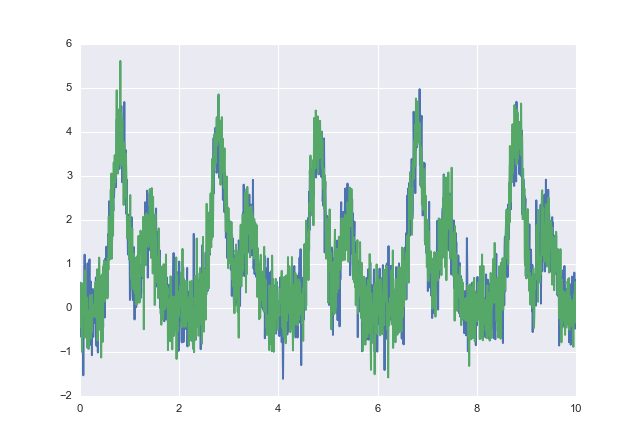

In [199]:
plt.figure()
plt.plot(time[:1500], counts2[:1500])
plt.plot(time[:1500], counts2[1500:3000])

In [200]:
nbins = 300*10
start_ind = 0
end_ind = start_ind + nbins

ac2_all, scale2_all = [], []

while end_ind <= len(counts1):
    ac2 = librosa.autocorrelate(np.array(counts2)[start_ind:end_ind], max_size=1500)
    ac2 = librosa.util.normalize(ac2, norm=np.inf)
    ac2_all.append(ac2)
    
    scale2 = librosa.fmt(ac2, n_fmt=750)
    scale2_all.append(scale2)
    
    start_ind += nbins
    end_ind += nbins

ac2_all = np.array(ac2_all)
scale2_all = np.array(scale2_all)

<IPython.core.display.Javascript object>


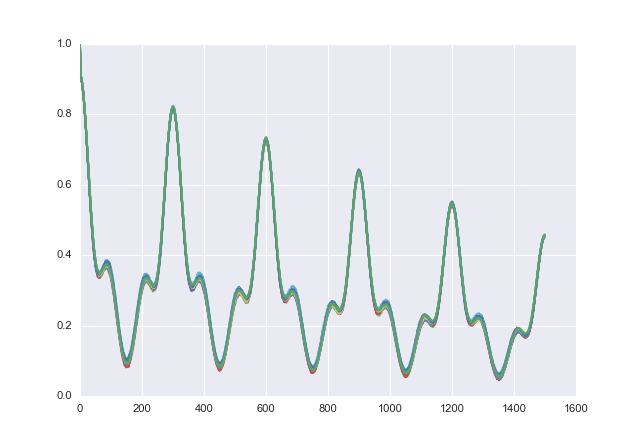

In [201]:
plt.figure()
for ac2 in ac2_all[:20]:
    plt.plot(ac2)

<IPython.core.display.Javascript object>


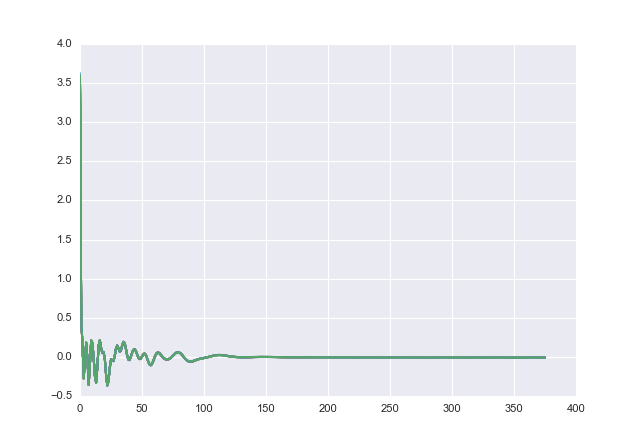

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [202]:
plt.figure()
for scale2 in scale2_all[:20]:
    plt.plot(scale2)

In [227]:
scale2_mean = np.mean(np.abs(scale2_all), axis=0)
scale2_std = np.std(np.abs(scale2_all), axis=0)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


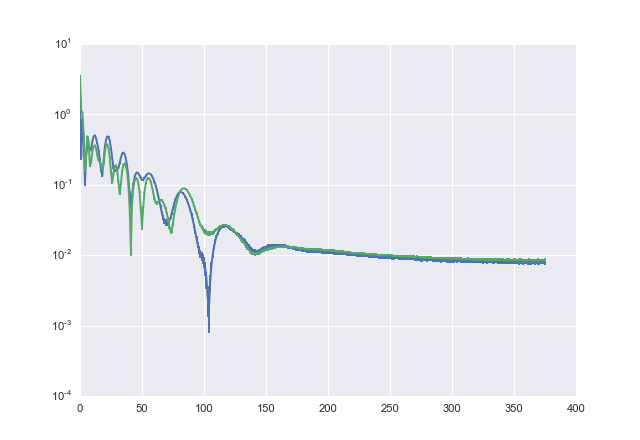

In [232]:
plt.figure()
plt.errorbar(np.arange(len(scale1_mean)), scale1_mean, yerr=scale1_std)
plt.errorbar(np.arange(len(scale2_mean)), scale2_mean, yerr=scale2_std)
plt.yscale("log")

Okay, that still doesn't look super different. Let's try a three-peak light curve:

In [207]:
nperiod = 1000

time, counts3 = [], []
for i in range(nperiod):
    counts3.extend(gaussian(x, a, loc-0.1, w/1.5) + 
                   gaussian(x,a/2.0, 0.5,w/1.5) + 
                   gaussian(x,a/2.0, 0.75,w/2.0) +
                   np.random.normal(0, 0.5,size=len(x)))
    
    time.extend(i*period+period*x)

counts3 = np.array(counts3)
time = np.array(time)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


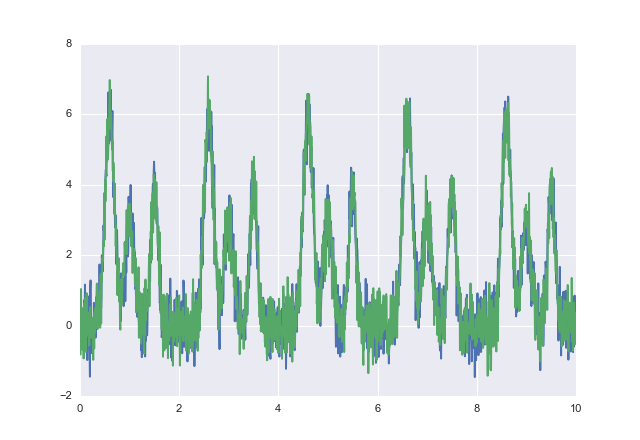

In [208]:
plt.figure()
plt.plot(time[:1500], counts3[:1500])
plt.plot(time[:1500], counts3[1500:3000])

In [209]:
nbins = 300*10
start_ind = 0
end_ind = start_ind + nbins

ac3_all, scale3_all = [], []

while end_ind <= len(counts3):
    ac3 = librosa.autocorrelate(np.array(counts3)[start_ind:end_ind], max_size=1500)
    ac3 = librosa.util.normalize(ac3, norm=np.inf)
    ac3_all.append(ac3)
    
    scale3 = librosa.fmt(ac3, n_fmt=512)
    scale3_all.append(scale3)
    
    start_ind += nbins
    end_ind += nbins

ac3_all = np.array(ac3_all)
scale3_all = np.array(scale3_all)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


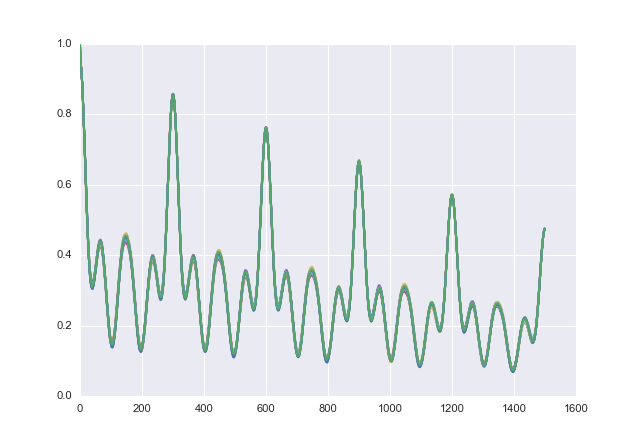

In [210]:
plt.figure()
for ac3 in ac3_all[:20]:
    plt.plot(ac3)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


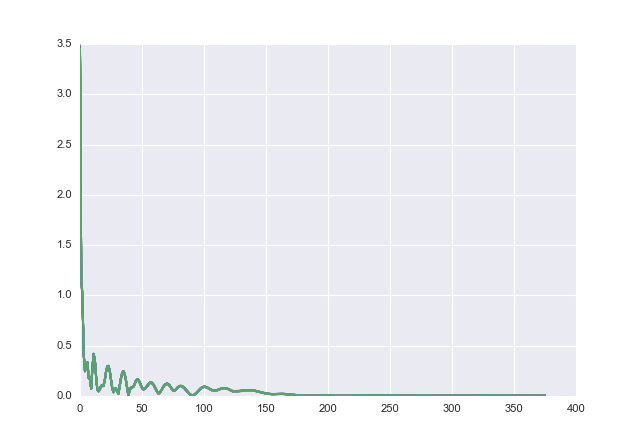

In [224]:
plt.figure()
for scale3 in scale3_all[:20]:
    plt.plot(np.abs(scale3))

In [225]:
scale3_mean = np.mean(np.abs(scale3_all), axis=0)
scale3_std = np.std(np.abs(scale3_all), axis=0)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


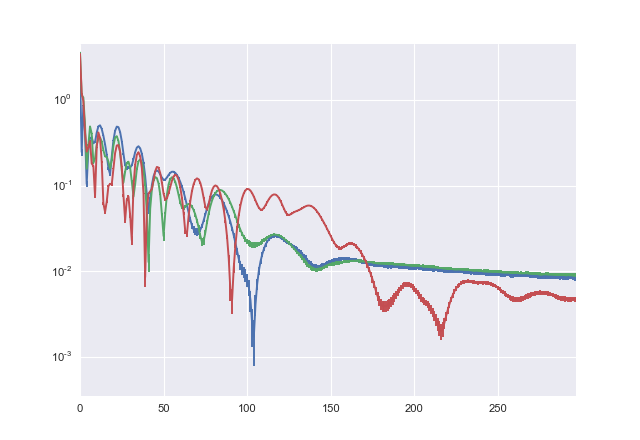

In [233]:
plt.figure()
plt.errorbar(np.arange(len(scale1_mean)), scale1_mean, yerr=scale1_std)
plt.errorbar(np.arange(len(scale2_mean)), scale2_mean, yerr=scale2_std)
plt.errorbar(np.arange(len(scale3_mean)), scale3_mean, yerr=scale3_std)
plt.yscale('log')

### Cosine Similarity

According to [Holzapfel et al](https://www.ics.forth.gr/netlab/data/J14.pdf), the cosine distance between the SMT (short-term Mellin transform) seems to work well to determine the similarity or dissimilarity between data sets.


In [234]:
def cosine_similarity(v1, v2):
    numer = v1.dot(v2)
    denom = np.linalg.norm(v1) * np.linalg.norm(v2)
    return 1.0 - numer / denom

Okay, now we can compute the cosine similarity between the data sets. First, we're going to combine all three data sets into a matrix.

In [235]:
scale_all = np.vstack([scale1_mean, scale2_mean, scale3_mean])

Now we can use the standard scaler to scale the data and whiten it to deal with some of the strong gradients in the small-scale part of the STM:

In [236]:
from sklearn.preprocessing import StandardScaler

In [237]:
stm_scaled = StandardScaler().fit_transform(scale_all)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


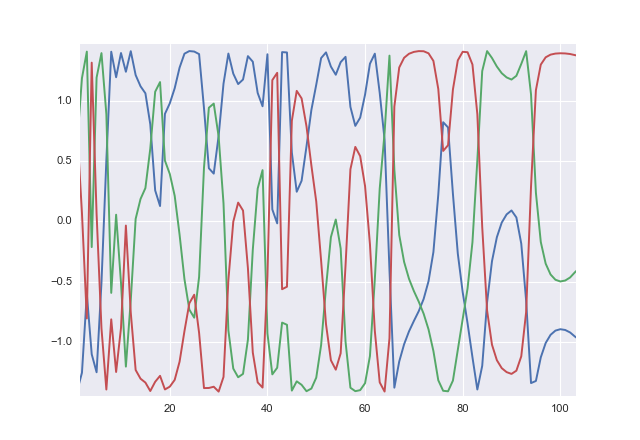

In [243]:
plt.figure()
plt.plot(np.arange(stm_scaled.shape[1]), stm_scaled[0,:])
plt.plot(np.arange(stm_scaled.shape[1]), stm_scaled[1,:])
plt.plot(np.arange(stm_scaled.shape[1]), stm_scaled[2,:])

Okay, cool! They now look pretty differently!
Let's compute the cosine similarity:

In [244]:
cosine_similarity(stm_scaled[0,:], stm_scaled[1,:])

0.61678640389236106

In [245]:
cosine_similarity(stm_scaled[0,:], stm_scaled[2,:])

1.8040979112537947

In [246]:
cosine_similarity(stm_scaled[1,:], stm_scaled[2,:])

1.8572541005044165

We don't really know what that means. What we want to do now is to simulate data sets that vary location, width and amplitude of the Gaussians, and then look at the cosine similarity depending on the number of Gaussians. 

Let's set this up!

In [250]:
def simulate_lightcurve(ngaussians, nbins, nperiod=1000):
    period = 2.0
    w = 0.05 * period
    
    x = np.linspace(0, 1, nbins, endpoint=False)
    time, counts = [], []
    
    time = np.zeros(nperiod*len(x))
    counts = np.zeros(nperiod*len(x))
    
    for j in range(ngaussians):
        a = np.random.uniform(0.5, 4.0)
        loc = np.random.uniform(0.2, 0.8)
        width = w/np.random.uniform(1.0, 3.0)
        
        for i in range(nperiod):
            counts[i*len(x):(i+1)*len(x)] += gaussian(x, a, loc, width)
            time[i*len(x):(i+1)*len(x)] = i*period+period*x

    for i in range(nperiod):
        counts[i*len(x):(i+1)*len(x)] += np.random.normal(0, 0.5,size=len(x))

    counts = np.array(counts)
    time = np.array(time)
    return time, counts, [ngaussians, a, loc, width]

In [251]:
ngaussians = 3 # number of peaks in each cycle
nbins = 300 # bins per period

time, counts, props = simulate_lightcurve(3, 300)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


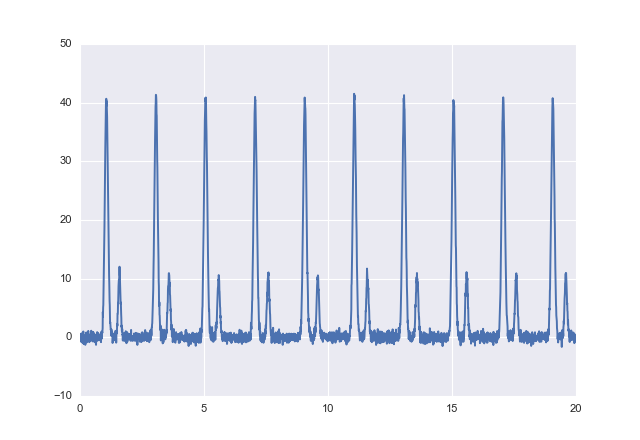

In [252]:
plt.figure()
plt.plot(time[:3000], counts[:3000])

Okay, cool. We now want to do this many times, then compute the STM for each. Let's also define a function to make the STM:

In [258]:
def compute_stm(counts, nbins=300, ncycles=5):

    start_ind = 0
    end_ind = start_ind + nbins*ncycles

    ac_all, scale_all = [], []

    while end_ind <= len(counts):
        ac = librosa.autocorrelate(counts[start_ind:end_ind], max_size=ncycles*nbins)
        ac = librosa.util.normalize(ac, norm=np.inf)
        ac_all.append(ac)

        scale = librosa.fmt(ac, n_fmt=512)
        scale_all.append(scale)

        start_ind += nbins
        end_ind += nbins

    ac_all = np.array(ac_all)
    scale_all = np.array(scale_all)
    return ac_all, scale_all

In [ ]:
ac_test, scale_test = compute_stm(counts)

In [ ]:
plt.figure()
for s in scale_test[:20]:
    plt.semilogy(np.arange(len(s)), np.abs(s))
    

Okay, now we're ready to set this up in a loop!